version
* 1.0 : 앞뒤로 null 제거됨
* 2.0 : isapllied 오류해결
* 3.0 : 의미로 null 제거됨
* 3.1 : loan_limit, rate = null
* 3.2 : loan_limit, rate = 0
* 3.3 : purpose label 한영 통일
* 4.0 : gender 원핫인코딩(null은 A), birth_year 는 min으로 결측값 제거

In [3]:
import pandas as pd
import numpy as np
import os
import random
from copy import deepcopy
import math
from itertools import product
import pickle
import joblib
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# 기본실험

## 기본실험 전처리

In [2]:
merged_ver_3_0 = pd.read_csv('./valiData/merged_ver_3_0.csv', index_col=0)

In [ ]:
merged_ver_3_0.shape

In [ ]:
merged_ver_3_0.columns

In [ ]:
droped_merged_ver_3_0=merged_ver_3_0.drop(
    ['application_id', 'user_id','insert_time','loanapply_insert_time', 
     'bank_id', 'product_id'],axis=1)

In [ ]:
droped_merged_ver_3_0.shape, \
droped_merged_ver_3_0[droped_merged_ver_3_0['is_applied']==1].shape

In [ ]:
cate_list = [
    'income_type',
    'employment_type',
    'houseown_type',
    'purpose',]

In [ ]:
for cate in cate_list:
    droped_merged_ver_3_0 = pd.get_dummies\
    (data = droped_merged_ver_3_0, columns=[cate], prefix=cate)

## 기본실험

In [28]:
tmp = droped_merged_ver_3_0.dropna()

In [29]:
tmp =pd.concat\
([tmp[tmp['is_applied']==0].sample(10_0000, random_state=42), tmp[tmp['is_applied']==1].sample(10_0000, random_state=42)])


In [31]:
X,y =tmp.loc[:, tmp.columns !='is_applied'] ,tmp['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [32]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7869

In [33]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.793827399380805

In [34]:
confusion_matrix(y_test, y_pred)

array([[15066,  4927],
       [ 3597, 16410]])

In [35]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.17839443368070892, 'credit_score')
(0.1436211695671614, 'loan_rate')
(0.09464072701871801, 'work_days')
(0.09252408251598689, 'loan_limit')
(0.09130523677339775, 'desired_amount')
(0.07246581328554809, 'birth_year')
(0.07139222469271646, 'yearly_income')
(0.07136817830972811, 'existing_loan_amt')
(0.05253856914865007, 'existing_loan_cnt')
(0.02002253181871006, 'income_type_EARNEDINCOME')
(0.012223362247392839, 'purpose_생활비')
(0.012031598424555404, 'gender')
(0.010395540762559392, 'employment_type_기타')
(0.00899595871356596, 'houseown_type_전월세')
(0.008810836448469996, 'employment_type_정규직')
(0.008335213871443443, 'houseown_type_기타가족소유')
(0.007386205997437072, 'houseown_type_자가')
(0.006962595856575358, 'purpose_대환대출')
(0.004447358875730672, 'income_type_PRIVATEBUSINESS')
(0.004400883357221721, 'employment_type_계약직')
(0.0039538371301764946, 'income_type_EARNEDINCOME2')
(0.003366932638196653, 'purpose_주택구입')
(0.0025993912189062715, 'purpose_사업자금')
(0.0024964964553419633, 'purpose_전월세보증금'

# loan_limit, rate 실험

## 전처리

In [2]:
merged_ver_3_1 = pd.read_csv('./expermData/merged_ver_3_1.csv', index_col=0)

In [3]:
merged_ver_3_1.shape

(13527250, 23)

In [4]:
merged_ver_3_1.columns

Index(['application_id', 'user_id', 'birth_year', 'gender', 'insert_time',
       'credit_score', 'yearly_income', 'income_type', 'employment_type',
       'houseown_type', 'desired_amount', 'purpose',
       'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'existing_loan_amt', 'loanapply_insert_time',
       'bank_id', 'product_id', 'loan_limit', 'loan_rate', 'is_applied',
       'work_days'],
      dtype='object')

In [5]:
droped_merged_ver_3_1=merged_ver_3_1.drop(
    ['application_id', 'user_id','insert_time','loanapply_insert_time', 
     'bank_id', 'product_id'],axis=1)

In [6]:
droped_merged_ver_3_1.shape, \
droped_merged_ver_3_1[droped_merged_ver_3_1['is_applied']==1].shape

((13527250, 17), (560336, 17))

In [7]:
cate_list = [
    'income_type',
    'employment_type',
    'houseown_type',
    'purpose',]

In [8]:
for cate in cate_list:
    droped_merged_ver_3_1 = pd.get_dummies\
    (data = droped_merged_ver_3_1, columns=[cate], prefix=cate)

In [9]:
droped_merged_ver_3_1.loc[droped_merged_ver_3_1[\
(droped_merged_ver_3_1['loan_limit'].isnull()==True)].index,
'loan_limit'] = 0

In [10]:
droped_merged_ver_3_1.loc[droped_merged_ver_3_1[\
(droped_merged_ver_3_1['loan_rate'].isnull()==True)].index,
'loan_rate'] = 0

## 실험 loan_limit, rate=0

In [11]:
tmp = droped_merged_ver_3_1.dropna()

In [12]:
tmp =pd.concat\
([tmp[tmp['is_applied']==0].sample(10_0000, random_state=42), tmp[tmp['is_applied']==1].sample(10_0000, random_state=42)])


In [13]:
X,y =tmp.loc[:, tmp.columns !='is_applied'] ,tmp['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.788925

In [15]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7960184581189147

In [16]:
confusion_matrix(y_test, y_pred)

array([[15083,  4910],
       [ 3533, 16474]])

In [17]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.17797150348559201, 'credit_score')
(0.14616328231665682, 'loan_rate')
(0.09484462815771962, 'work_days')
(0.09145006808631105, 'loan_limit')
(0.0909561450633737, 'desired_amount')
(0.0721808593365446, 'birth_year')
(0.07128421222492334, 'yearly_income')
(0.07080026772419709, 'existing_loan_amt')
(0.05265038577662984, 'existing_loan_cnt')
(0.02123480349639912, 'income_type_EARNEDINCOME')
(0.012118478796338017, 'purpose_생활비')
(0.011923167020370022, 'gender')
(0.009422627687504334, 'employment_type_기타')
(0.009367933711858543, 'employment_type_정규직')
(0.008860728963390354, 'houseown_type_전월세')
(0.008281659541318813, 'houseown_type_기타가족소유')
(0.0074181777703710705, 'houseown_type_자가')
(0.0067672942519031365, 'purpose_대환대출')
(0.004402056710156144, 'employment_type_계약직')
(0.004289564589410357, 'income_type_PRIVATEBUSINESS')
(0.0037157357540004254, 'income_type_EARNEDINCOME2')
(0.0031663138509691806, 'purpose_주택구입')
(0.002622867014219127, 'purpose_사업자금')
(0.002617146905524058, 'purpose_전월세보증금

좋앗다~~


# credit_score 실험

## 전처리

In [21]:
(merged_ver_3_1.isnull().sum())[merged_ver_3_1.isnull().sum()!=0]

birth_year       108227
gender           108227
credit_score    1311773
loan_limit         7382
loan_rate          7382
is_applied      3257239
dtype: int64

In [20]:
(merged_ver_3_1[merged_ver_3_1['is_applied'].isnull()==True]\
 .isnull().sum())[merged_ver_3_1[merged_ver_3_1['is_applied'].isnull()==True].isnull().sum()!=0]


birth_year        30960
gender            30960
credit_score     256483
loan_limit         1757
loan_rate          1757
is_applied      3257239
dtype: int64

전처리는 필요없음

## 실험

In [22]:
tmp = droped_merged_ver_3_1.dropna()

In [24]:
tmp2 =droped_merged_ver_3_1.drop(['credit_score'],axis=1).dropna()

In [25]:
tmp3 = droped_merged_ver_3_1[droped_merged_ver_3_1['credit_score'].isnull()==True]\
.drop(['credit_score'],axis=1).dropna()

In [26]:
tmp =pd.concat\
([tmp[tmp['is_applied']==0].sample(10_0000, random_state=42), tmp[tmp['is_applied']==1].sample(10_0000, random_state=42)])


In [27]:
tmp2 =pd.concat\
([tmp2[tmp2['is_applied']==0].sample(10_0000, random_state=42), \
  tmp2[tmp2['is_applied']==1].sample(10_0000, random_state=42)])


In [34]:
tmp3[tmp3['is_applied']==1].shape

(42217, 42)

In [40]:
tmp3 =pd.concat\
([tmp3[tmp3['is_applied']==0].sample(42217, random_state=42), \
  tmp3[tmp3['is_applied']==1].sample(42217, random_state=42)])


### 실험 1

In [29]:
X,y =tmp.loc[:, tmp.columns !='is_applied'] ,tmp['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [30]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.788925

In [31]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7960184581189147

In [32]:
confusion_matrix(y_test, y_pred)

array([[15083,  4910],
       [ 3533, 16474]])

In [33]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.17797150348559201, 'credit_score')
(0.14616328231665682, 'loan_rate')
(0.09484462815771962, 'work_days')
(0.09145006808631105, 'loan_limit')
(0.0909561450633737, 'desired_amount')
(0.0721808593365446, 'birth_year')
(0.07128421222492334, 'yearly_income')
(0.07080026772419709, 'existing_loan_amt')
(0.05265038577662984, 'existing_loan_cnt')
(0.02123480349639912, 'income_type_EARNEDINCOME')
(0.012118478796338017, 'purpose_생활비')
(0.011923167020370022, 'gender')
(0.009422627687504334, 'employment_type_기타')
(0.009367933711858543, 'employment_type_정규직')
(0.008860728963390354, 'houseown_type_전월세')
(0.008281659541318813, 'houseown_type_기타가족소유')
(0.0074181777703710705, 'houseown_type_자가')
(0.0067672942519031365, 'purpose_대환대출')
(0.004402056710156144, 'employment_type_계약직')
(0.004289564589410357, 'income_type_PRIVATEBUSINESS')
(0.0037157357540004254, 'income_type_EARNEDINCOME2')
(0.0031663138509691806, 'purpose_주택구입')
(0.002622867014219127, 'purpose_사업자금')
(0.002617146905524058, 'purpose_전월세보증금

### 실험 2

In [35]:
X,y =tmp2.loc[:, tmp2.columns !='is_applied'] ,tmp2['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [36]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.74605

In [37]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.747124719940254

In [38]:
confusion_matrix(y_test, y_pred)

array([[14836,  5157],
       [ 5001, 15006]])

In [39]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.15107687768564718, 'loan_rate')
(0.12393065020727541, 'work_days')
(0.11805079634282013, 'desired_amount')
(0.11262390293990325, 'loan_limit')
(0.094267982793778, 'birth_year')
(0.0938797001665162, 'yearly_income')
(0.08903165594038284, 'existing_loan_amt')
(0.0672133717694632, 'existing_loan_cnt')
(0.024341972288206146, 'income_type_EARNEDINCOME')
(0.01606382885761118, 'purpose_생활비')
(0.014558416907771217, 'gender')
(0.009610127523452751, 'employment_type_기타')
(0.009540368040447982, 'employment_type_정규직')
(0.008950559160281863, 'houseown_type_전월세')
(0.008521570391566355, 'houseown_type_기타가족소유')
(0.007832502256640563, 'houseown_type_자가')
(0.007363152613984208, 'purpose_대환대출')
(0.004715371624028662, 'purpose_주택구입')
(0.0046724118075063305, 'employment_type_계약직')
(0.0042497608800680774, 'income_type_PRIVATEBUSINESS')
(0.004218779499548439, 'income_type_EARNEDINCOME2')
(0.003616043295418978, 'purpose_전월세보증금')
(0.003074049571609652, 'purpose_사업자금')
(0.0029809154022362393, 'income_type_OT

### 실험 3

In [41]:
X,y =tmp3.loc[:, tmp3.columns !='is_applied'] ,tmp3['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [42]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7968851779475336

In [43]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7992038402997308

In [44]:
confusion_matrix(y_test, y_pred)

array([[6631, 1825],
       [1605, 6826]])

In [45]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.1787443238182265, 'loan_rate')
(0.12936711593767797, 'desired_amount')
(0.12359961237794387, 'loan_limit')
(0.12186481938146781, 'work_days')
(0.10092328813118386, 'birth_year')
(0.0943581147218599, 'yearly_income')
(0.0374253186680348, 'income_type_EARNEDINCOME')
(0.031877551850891084, 'purpose_생활비')
(0.021767100035479946, 'existing_loan_amt')
(0.020342808125763955, 'existing_loan_cnt')
(0.015146607201868304, 'gender')
(0.015082632388260943, 'employment_type_정규직')
(0.00991171968026878, 'employment_type_기타')
(0.009379431998946097, 'houseown_type_전월세')
(0.009162118170184128, 'purpose_주택구입')
(0.00904248484764218, 'houseown_type_자가')
(0.008708609284710882, 'houseown_type_기타가족소유')
(0.007731026876277425, 'purpose_대환대출')
(0.007343278463957453, 'purpose_전월세보증금')
(0.005970171079968286, 'income_type_PRIVATEBUSINESS')
(0.004941903032274442, 'income_type_EARNEDINCOME2')
(0.004911754771341773, 'purpose_사업자금')
(0.004363368076764135, 'employment_type_계약직')
(0.004064575388018548, 'income_type_OTHE

null인 것과 나누는 것이 좋다

### 추가실험

In [56]:
tmp=droped_merged_ver_3_1.copy()

In [57]:
tmp['credit_score'].fillna(-100, inplace=True)

In [58]:
tmp.dropna(inplace=True)

In [61]:
tmp =pd.concat\
([tmp[tmp['is_applied']==0].sample(10_0000, random_state=42), tmp[tmp['is_applied']==1].sample(10_0000, random_state=42)])


In [62]:
X,y =tmp.loc[:, tmp.columns !='is_applied'] ,tmp['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [63]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.785475

In [64]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7912114649991483

In [65]:
confusion_matrix(y_test, y_pred)

array([[15160,  4833],
       [ 3748, 16259]])

In [66]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.16018533651184086, 'credit_score')
(0.14615326922011523, 'loan_rate')
(0.09783747523057147, 'work_days')
(0.09696348962489053, 'desired_amount')
(0.09283601745407662, 'loan_limit')
(0.07474338107342292, 'birth_year')
(0.07339598787540225, 'yearly_income')
(0.06850335291850879, 'existing_loan_amt')
(0.05142414441373968, 'existing_loan_cnt')
(0.021488903917886534, 'income_type_EARNEDINCOME')
(0.013204884802119767, 'purpose_생활비')
(0.012551350083321158, 'gender')
(0.01019410013887805, 'employment_type_기타')
(0.009267128610911547, 'employment_type_정규직')
(0.00894778096252075, 'houseown_type_전월세')
(0.008316588677987406, 'houseown_type_기타가족소유')
(0.007583617646825401, 'houseown_type_자가')
(0.006891416046068154, 'purpose_대환대출')
(0.0046671218858219295, 'income_type_PRIVATEBUSINESS')
(0.00449641305297949, 'employment_type_계약직')
(0.00422052527920902, 'income_type_EARNEDINCOME2')
(0.0037254521104504775, 'purpose_주택구입')
(0.00301821975380785, 'purpose_전월세보증금')
(0.0028220216840337342, 'purpose_사업자금')


# 중간정리

## 전처리

In [2]:
merged_ver_3_3 = pd.read_csv('./expermData/merged_ver_3_3.csv', index_col=0)

In [4]:
merged_ver_3_3.shape

(13527250, 23)

In [5]:
merged_ver_3_3.columns

Index(['application_id', 'user_id', 'birth_year', 'gender', 'insert_time',
       'credit_score', 'yearly_income', 'income_type', 'employment_type',
       'houseown_type', 'desired_amount', 'purpose',
       'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'existing_loan_amt', 'loanapply_insert_time',
       'bank_id', 'product_id', 'loan_limit', 'loan_rate', 'is_applied',
       'work_days'],
      dtype='object')

In [6]:
droped_merged_ver_3_3=merged_ver_3_3.drop(
    ['application_id', 'user_id','insert_time','loanapply_insert_time', 
     'bank_id', 'product_id'],axis=1)

In [7]:
droped_merged_ver_3_3.shape, \
droped_merged_ver_3_3[droped_merged_ver_3_3['is_applied']==1].shape

((13527250, 17), (560336, 17))

In [8]:
cate_list = [
    'income_type',
    'employment_type',
    'houseown_type',
    'purpose',]

In [10]:
for cate in cate_list:
    droped_merged_ver_3_3 = pd.get_dummies\
    (data = droped_merged_ver_3_3, columns=[cate], prefix=cate)

## 실험

비교는 credit_csore 실험의 실험 1을 보셈

In [11]:
tmp = droped_merged_ver_3_3.dropna()

In [12]:
tmp =pd.concat\
([tmp[tmp['is_applied']==0].sample(10_0000, random_state=42), tmp[tmp['is_applied']==1].sample(10_0000, random_state=42)])


In [13]:
X,y =tmp.loc[:, tmp.columns !='is_applied'] ,tmp['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.789275

In [15]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7963468554446833

In [16]:
confusion_matrix(y_test, y_pred)

array([[15091,  4902],
       [ 3527, 16480]])

In [17]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.1796537505497196, 'credit_score')
(0.1465656126449938, 'loan_rate')
(0.0952119758971926, 'work_days')
(0.0910997168284669, 'loan_limit')
(0.09087849002534662, 'desired_amount')
(0.07217670846946472, 'birth_year')
(0.0711426069413473, 'yearly_income')
(0.07089902671103351, 'existing_loan_amt')
(0.05225155404943067, 'existing_loan_cnt')
(0.020573348238798448, 'income_type_EARNEDINCOME')
(0.012586793119750098, 'purpose_생활비')
(0.012051531653140735, 'gender')
(0.009095328103286974, 'houseown_type_전월세')
(0.008933656665943713, 'employment_type_기타')
(0.008461511784262412, 'houseown_type_기타가족소유')
(0.008447711842180345, 'employment_type_정규직')
(0.007518595759630928, 'houseown_type_자가')
(0.006786432634475322, 'purpose_대환대출')
(0.004617241262317684, 'income_type_PRIVATEBUSINESS')
(0.004390953477422594, 'employment_type_계약직')
(0.0037668492417464216, 'income_type_EARNEDINCOME2')
(0.00334696955138854, 'purpose_주택구입')
(0.003130454129386017, 'income_type_OTHERINCOME')
(0.002642421982083296, 'purpose_사

# birth year & gender

## 전처리
* birth year = median
* gender은 원핫인코딩

In [18]:
droped_merged_ver_3_3=merged_ver_3_3.drop(
    ['application_id', 'user_id','insert_time','loanapply_insert_time', 
     'bank_id', 'product_id'],axis=1)

In [19]:
droped_merged_ver_3_3.shape, \
droped_merged_ver_3_3[droped_merged_ver_3_3['is_applied']==1].shape

((13527250, 17), (560336, 17))

In [20]:
droped_merged_ver_3_3['gender'].replace('0', 'F', inplace=True)
droped_merged_ver_3_3['gender'].replace('1', 'M', inplace=True)
droped_merged_ver_3_3['gender'].fillna('A', inplace=True)

In [21]:
cate_list = [
    'income_type',
    'employment_type',
    'houseown_type',
    'purpose',
    'gender']

In [22]:
for cate in cate_list:
    droped_merged_ver_3_3 = pd.get_dummies\
    (data = droped_merged_ver_3_3, columns=[cate], prefix=cate)

In [23]:
droped_merged_ver_3_3.shape, \
droped_merged_ver_3_3[droped_merged_ver_3_3['is_applied']==1].shape

((13527250, 37), (560336, 37))

## 실험

In [24]:
tmp = droped_merged_ver_3_3.dropna()

In [48]:
tmp2 = droped_merged_ver_3_3.copy()

In [39]:
tmp2['birth_year'].fillna(tmp2['birth_year'].median(), inplace=True)

In [41]:
tmp2.dropna(inplace=True)

In [51]:
tmp3 = droped_merged_ver_3_3.copy()
tmp3['birth_year'].fillna(tmp3['birth_year'].min(), inplace=True)
tmp3.dropna(inplace=True)

In [52]:
tmp4 = droped_merged_ver_3_3.copy()
tmp4['birth_year'].fillna(tmp4['birth_year'].max(), inplace=True)
tmp4.dropna(inplace=True)

### 실험 1

In [ ]:
tmp =pd.concat\
([tmp[tmp['is_applied']==0].sample(10_0000, random_state=42), tmp[tmp['is_applied']==1].sample(10_0000, random_state=42)])


In [26]:
X,y =tmp.loc[:, tmp.columns !='is_applied'] ,tmp['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [27]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7909

In [28]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7979417306856066

In [29]:
confusion_matrix(y_test, y_pred)

array([[15121,  4872],
       [ 3492, 16515]])

In [30]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.180368048299661, 'credit_score')
(0.14575630615255575, 'loan_rate')
(0.09335029477073475, 'work_days')
(0.09172743321486607, 'desired_amount')
(0.09002603469201027, 'loan_limit')
(0.07082338243545364, 'birth_year')
(0.07001184192375745, 'existing_loan_amt')
(0.07000114424687923, 'yearly_income')
(0.05198196592228228, 'existing_loan_cnt')
(0.022274439196809052, 'income_type_EARNEDINCOME')
(0.011903638686506448, 'purpose_생활비')
(0.0098403731652951, 'houseown_type_전월세')
(0.009106197963960654, 'houseown_type_기타가족소유')
(0.00891420265653503, 'employment_type_기타')
(0.008617669157953804, 'employment_type_정규직')
(0.008259197845227467, 'gender_0.0')
(0.008253894449947912, 'gender_1.0')
(0.007934551903430861, 'houseown_type_자가')
(0.006824420367412049, 'purpose_대환대출')
(0.00448650826744079, 'employment_type_계약직')
(0.004308239590605819, 'income_type_PRIVATEBUSINESS')
(0.0032972055923565307, 'income_type_EARNEDINCOME2')
(0.003006562018630654, 'purpose_주택구입')
(0.0027065663360577325, 'income_type_OTHER

### 실험 2

In [42]:
tmp2 =pd.concat\
([tmp2[tmp2['is_applied']==0].sample(10_0000, random_state=42), tmp2[tmp2['is_applied']==1].sample(10_0000, random_state=42)])


In [43]:
X,y =tmp2.loc[:, tmp2.columns !='is_applied'] ,tmp2['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [44]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7897

In [45]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7962998837659822

In [46]:
confusion_matrix(y_test, y_pred)

array([[15146,  4847],
       [ 3565, 16442]])

In [47]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.1854474747360775, 'credit_score')
(0.14431822018624563, 'loan_rate')
(0.092817602682772, 'work_days')
(0.08982160821979354, 'loan_limit')
(0.08852024739519998, 'desired_amount')
(0.07015944564308596, 'birth_year')
(0.06976951264055092, 'yearly_income')
(0.06953038245380945, 'existing_loan_amt')
(0.050328495504377055, 'existing_loan_cnt')
(0.022871590625736845, 'income_type_EARNEDINCOME')
(0.012805157637215738, 'purpose_생활비')
(0.009824966278404085, 'houseown_type_전월세')
(0.009308353699275457, 'houseown_type_기타가족소유')
(0.009005261552930055, 'employment_type_기타')
(0.008273044583935801, 'gender_1.0')
(0.00822581999140221, 'gender_0.0')
(0.008187002511617185, 'employment_type_정규직')
(0.008047749422587867, 'houseown_type_자가')
(0.006909503314851159, 'purpose_대환대출')
(0.004560110042817969, 'employment_type_계약직')
(0.004069267643444835, 'income_type_PRIVATEBUSINESS')
(0.0035460800430757405, 'income_type_EARNEDINCOME2')
(0.0030006211559421504, 'purpose_주택구입')
(0.0027425408883084046, 'income_type_O

### 실험 3

In [53]:
tmp3 =pd.concat\
([tmp3[tmp3['is_applied']==0].sample(10_0000, random_state=42), tmp3[tmp3['is_applied']==1].sample(10_0000, random_state=42)])


In [54]:
X,y =tmp3.loc[:, tmp3.columns !='is_applied'] ,tmp3['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [55]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7903

In [56]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.796881053855095

In [57]:
confusion_matrix(y_test, y_pred)

array([[15158,  4835],
       [ 3553, 16454]])

In [58]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.18543420246349598, 'credit_score')
(0.14457724676460518, 'loan_rate')
(0.09308709803847773, 'work_days')
(0.08997902397836428, 'desired_amount')
(0.08967608958811345, 'loan_limit')
(0.07043325388857552, 'birth_year')
(0.06978731247099709, 'yearly_income')
(0.06968760280109805, 'existing_loan_amt')
(0.0500316929093677, 'existing_loan_cnt')
(0.02274843418645898, 'income_type_EARNEDINCOME')
(0.01202785530303554, 'purpose_생활비')
(0.009726593567695315, 'houseown_type_전월세')
(0.00939124435895142, 'houseown_type_기타가족소유')
(0.009235245487438511, 'employment_type_기타')
(0.00818305157463071, 'gender_0.0')
(0.008171301741154035, 'gender_1.0')
(0.008001352154595959, 'employment_type_정규직')
(0.007985902397920167, 'houseown_type_자가')
(0.006591430780876071, 'purpose_대환대출')
(0.004556029610898176, 'employment_type_계약직')
(0.00444095471673803, 'income_type_PRIVATEBUSINESS')
(0.0035060752912522662, 'income_type_EARNEDINCOME2')
(0.002831240930009369, 'income_type_OTHERINCOME')
(0.002807638217875765, 'purpose

### 실험 4

In [59]:
tmp4 =pd.concat\
([tmp4[tmp4['is_applied']==0].sample(10_0000, random_state=42), tmp4[tmp4['is_applied']==1].sample(10_0000, random_state=42)])


In [60]:
X,y =tmp4.loc[:, tmp4.columns !='is_applied'] ,tmp4['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [61]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.789325

In [62]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7960304973980394

In [63]:
confusion_matrix(y_test, y_pred)

array([[15129,  4864],
       [ 3563, 16444]])

In [64]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.1822650129186153, 'credit_score')
(0.14474442014487005, 'loan_rate')
(0.09324110434200217, 'work_days')
(0.09135877731180071, 'loan_limit')
(0.08976680994477851, 'desired_amount')
(0.07033858967500721, 'birth_year')
(0.06982593570850532, 'existing_loan_amt')
(0.06955958043498578, 'yearly_income')
(0.05093509727353179, 'existing_loan_cnt')
(0.022627458820920633, 'income_type_EARNEDINCOME')
(0.012698794903312651, 'purpose_생활비')
(0.00956050936460091, 'houseown_type_전월세')
(0.009195763383477511, 'employment_type_기타')
(0.009102104198534206, 'houseown_type_기타가족소유')
(0.008670132865251326, 'employment_type_정규직')
(0.008161681216762947, 'gender_1.0')
(0.00807498038750933, 'gender_0.0')
(0.007880146745546242, 'houseown_type_자가')
(0.006749408628882011, 'purpose_대환대출')
(0.004623065340611754, 'employment_type_계약직')
(0.004124123689296935, 'income_type_PRIVATEBUSINESS')
(0.0037499349912294, 'income_type_EARNEDINCOME2')
(0.0030355577307841085, 'purpose_주택구입')
(0.002767490550772998, 'income_type_OTHER

min이 제일 좋다

# 새로운 변수 추가

## 전처리

In [4]:
merged_ver_4_0 = pd.read_csv('./expermData/merged_ver_4_0.csv', index_col=0)

In [5]:
merged_ver_4_0.columns

Index(['Unnamed: 0.1', 'application_id', 'user_id', 'birth_year', 'gender',
       'insert_time', 'credit_score', 'yearly_income', 'income_type',
       'employment_type', 'houseown_type', 'desired_amount', 'purpose',
       'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'existing_loan_amt', 'loanapply_insert_time',
       'bank_id', 'product_id', 'loan_limit', 'loan_rate', 'is_applied',
       'work_days'],
      dtype='object')

In [6]:
merged_ver_4_0.drop(['Unnamed: 0.1'], inplace=True, axis=1)

In [7]:
merged_ver_4_0.dropna(inplace=True)

In [8]:
droped_merged_ver_4_0= merged_ver_4_0.drop(
    ['application_id', 'user_id',
     #'insert_time','loanapply_insert_time', 
     'bank_id', 'product_id'],axis=1)

In [9]:
cate_list = [
    'income_type',
    'employment_type',
    'houseown_type',
    'purpose',
    'gender'
]

In [10]:
for cate in cate_list:
    droped_merged_ver_4_0 = pd.get_dummies\
    (data = droped_merged_ver_4_0, columns=[cate], prefix=cate)

## 새로운 변수
* ratio_EY : 기대출금액/연소득
* ratio_DY : 대출희망금액/연소득
* ratio_LY : 승인한도/연소득
* ratio_LD : 승인한도/대출희망금액
* perseonal_rehabilitation_n : 개인회생자아님
* perseonal_rehabilitation_y : 개인회생자임
* perseonal_rehabilitation_c : 개인회생납부함
* time_interval : 한도조회 - 생성일시
* link_account : 계좌 연결여부

In [11]:
tmp = droped_merged_ver_4_0.copy()
tmp =pd.concat\
([tmp[tmp['is_applied']==0].sample(10_0000, random_state=42), tmp[tmp['is_applied']==1].sample(10_0000, random_state=42)])
tmp['yearly_income'].replace(0, 1, inplace=True)
tmp['desired_amount'].replace(0, 1, inplace=True)
tmp['ratio_EY'] = tmp['existing_loan_amt']/tmp['yearly_income']
tmp['ratio_DY'] = tmp['desired_amount']/tmp['yearly_income']
tmp['ratio_LY'] = tmp['loan_limit']/tmp['yearly_income']
tmp['ratio_LD'] = tmp['loan_limit']/tmp['desired_amount']
tmp['personal_rehabilitation_c'] = tmp['personal_rehabilitation_complete_yn']
tmp['personal_rehabilitation_n'] = 0
tmp['personal_rehabilitation_y'] = 0
tmp.loc[tmp[tmp["personal_rehabilitation_yn"]==0].index, 'personal_rehabilitation_n']=1
tmp.loc[tmp[(tmp["personal_rehabilitation_yn"]==1)&
           (tmp["personal_rehabilitation_complete_yn"]==0)
           ].index, 'personal_rehabilitation_y']=1

In [12]:
tmp['time_interval'] = pd.to_datetime(tmp['loanapply_insert_time']) - pd.to_datetime(tmp['insert_time'])
tmp['time_interval']=tmp['time_interval'].dt.total_seconds()

In [13]:
tmp['age'] = 2022-tmp['birth_year']

In [14]:
tmp.drop(['insert_time','loanapply_insert_time', 'birth_year',
'personal_rehabilitation_yn','personal_rehabilitation_complete_yn']
         ,axis=1,inplace=True)

In [15]:
tmp['link_account'] = 0
tmp.loc[tmp[tmp["loan_rate"]==0].index, 'link_account']=1

In [16]:
X,y =tmp.loc[:, tmp.columns !='is_applied'] ,tmp['is_applied']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7876

In [17]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7948519824214033

In [18]:
confusion_matrix(y_test, y_pred)

array([[15045,  4948],
       [ 3548, 16459]])

In [19]:
print(*sorted(zip(model.feature_importances_, X_test.columns), reverse=True), sep='\n')

(0.15799684932799607, 'credit_score')
(0.11198828790899498, 'loan_rate')
(0.07352963619851176, 'ratio_LD')
(0.06459377445035742, 'work_days')
(0.06100294907540637, 'ratio_DY')
(0.05697538080314204, 'ratio_LY')
(0.04979685131000594, 'ratio_EY')
(0.04950674762745688, 'desired_amount')
(0.04878127158815115, 'age')
(0.04825171722668481, 'loan_limit')
(0.04481578227534114, 'existing_loan_amt')
(0.04358961691119696, 'yearly_income')
(0.037027488229659095, 'existing_loan_cnt')
(0.03412063179337328, 'time_interval')
(0.019747752371167313, 'income_type_EARNEDINCOME')
(0.009897090821147496, 'purpose_생활비')
(0.00838551352258688, 'employment_type_기타')
(0.007937833344148774, 'houseown_type_전월세')
(0.007647047424413611, 'employment_type_정규직')
(0.007627554864457305, 'houseown_type_기타가족소유')
(0.00662532542814179, 'gender_1.0')
(0.006591803184671249, 'gender_0.0')
(0.006431612716661099, 'houseown_type_자가')
(0.005892710590125872, 'purpose_대환대출')
(0.004003871051153474, 'employment_type_계약직')
(0.003938504735

In [20]:
feature_list=sorted(zip(model.feature_importances_, X_test.columns))

# feature 버리기

In [56]:
acc_list=[]
f1_list=[]
for im, feature in tqdm(feature_list):
    X_train.drop([feature], axis=1, inplace=True)
    X_test.drop([feature], axis=1, inplace=True)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    acc_list.append(model.score(X_test,y_test))
    f1_list.append(f1_score(y_test, model.predict(X_test)))

 98%|█████████████████████████████████████████████████████████████████████████████████  | 42/43 [15:25<00:22, 22.04s/it]


ValueError: at least one array or dtype is required

([<matplotlib.axis.XTick at 0x7fcf839325b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

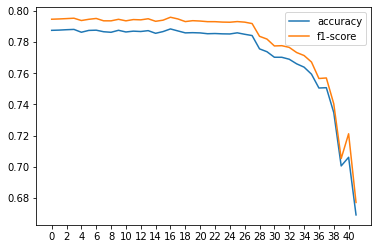

In [65]:
plt.plot(range(len(acc_list)), acc_list, label = 'accuracy')
plt.plot(range(len(acc_list)), f1_list, label = 'f1-score')
plt.legend()
plt.xticks([i*2 for i in range(len(acc_list)//2)])

In [70]:
print(*zip(enumerate(acc_list),feature_list), sep='\n')

((0, 0.7876), (0.00018093607825094715, 'houseown_type_배우자'))
((1, 0.78775), (0.0003599906949060274, 'personal_rehabilitation_y'))
((2, 0.788), (0.00042969397487620085, 'personal_rehabilitation_n'))
((3, 0.7882), (0.0004968564734022254, 'personal_rehabilitation_c'))
((4, 0.786375), (0.0005190597547952394, 'purpose_자동차구입'))
((5, 0.78755), (0.0006796923680722346, 'gender_A'))
((6, 0.7877), (0.0008577182306194516, 'link_account'))
((7, 0.7867), (0.0011607053860557622, 'purpose_투자'))
((8, 0.78635), (0.0013579490349748704, 'income_type_PRACTITIONER'))
((9, 0.787625), (0.0014277989231926008, 'employment_type_일용직'))
((10, 0.78655), (0.0017967618232025068, 'purpose_전월세보증금'))
((11, 0.787075), (0.0018112178803590111, 'income_type_FREELANCER'))
((12, 0.78685), (0.0018346790322008707, 'purpose_기타'))
((13, 0.7874), (0.0019286160917316242, 'purpose_주택구입'))
((14, 0.7857), (0.002190198730016675, 'purpose_사업자금'))
((15, 0.7868), (0.002745549688845994, 'income_type_OTHERINCOME'))
((16, 0.7885), (0.0035189

In [23]:
# X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

# X_train.drop([f for i,f in feature_list[:16]], axis=1, inplace=True)
# X_test.drop([f for i,f in feature_list[:16]], axis=1, inplace=True)


In [24]:
# X_train.to_csv('./expermData/X_train.csv')
# X_test.to_csv('./expermData/X_test.csv')
# y_train.to_csv('./expermData/y_train.csv')
# y_test.to_csv('./expermData/y_test.csv')

In [21]:
[f for i,f in feature_list[:16]]

['houseown_type_배우자',
 'personal_rehabilitation_y',
 'personal_rehabilitation_n',
 'personal_rehabilitation_c',
 'purpose_자동차구입',
 'gender_A',
 'link_account',
 'purpose_투자',
 'income_type_PRACTITIONER',
 'employment_type_일용직',
 'purpose_전월세보증금',
 'income_type_FREELANCER',
 'purpose_기타',
 'purpose_주택구입',
 'purpose_사업자금',
 'income_type_OTHERINCOME']